---
title: "Introduccion EDO con Julia"
author:
  - name: Luis E. Ascencio G. 
    orcid: 0009-0009-1694-5993
    email: luis.ascencio@cimat.mx
    affiliation: 
      - name: CIMAT
        city: Guanajuato
        state: Guanajuato
        url: https://www.cimat.mx
abstract: > 
 En este NoteBook encontraras codigo para manejar EDO con el lenguaje de programacion Julia.
keywords:
  - Ecuaciones Diferenciales Ordinarias
  - Metodos Numericos
  - Campos Vectoriales 
  - Curvas Integrales 
license: "CC BY"
copyright: 
  holder: Luis E. Ascencio G.
  year: 2026
citation: 
  container-title: CIMAT
  volume: 1
  issue: 1
  doi: 000000/00000000
funding: "This work was supported by the Mexican Secretariat of Science, Humanities, Technology, and Innovation (SECIHTI, México) project CBF2023-2024-3976. Luis Enrique Ascencio Gorozpe is a doctoral student from the PhD in Probability and Statistics program, at Mathematics research center (CIMAT), he received fellowship with number (CVU) 695305 from SECIHTI."
format:
  pdf:
    documentclass: scrartcl
    toc: true
    number-sections: true
    colorlinks: true
---

# Importar librerias

In [1]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Plots")

using DifferentialEquations, Plots

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [2]:
import DifferentialEquations as DE # libreria para solucionar EDO con metodos numericos
import Plots                        # Libreria para graficar

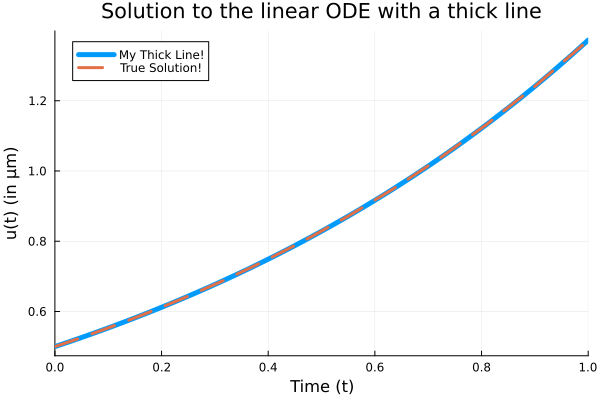

In [3]:
# Definicion de la funcion asociada a la EDO de primer orden
f(u, p, t) = 1.01 * u

# Definicion de condicion inicial
u0 = 1 / 2

# Definicion del espacio de tiempo para la solucion de la EDO
tspan = (0.0, 1.0)

# Definicion del "objeto" asociado a la EDO
prob = DE.ODEProblem(f, u0, tspan)

# Solucion numerica 
sol = DE.solve(prob, DE.Tsit5(), reltol = 1e-8, abstol = 1e-8)


# Graficas de las soluciones 
Plots.plot(sol, linewidth = 5, title = "Solution to the linear ODE with a thick line",
    xaxis = "Time (t)", yaxis = "u(t) (in μm)", label = "My Thick Line!") # legend=false
Plots.plot!(sol.t, t -> 0.5 * exp(1.01t), lw = 3, ls = :dash, label = "True Solution!")

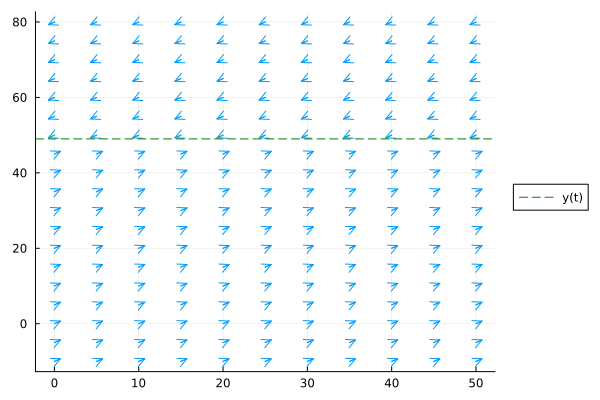

In [4]:
xs = 0:5:50
ys = -10:5:80

using LinearAlgebra, Plots

# dx/dy = f(y,x)
df(x, y) = normalize([9.8-(y/5), 9.8-(y/5)])  

xxs = [x for x in xs for y in ys]
yys = [y for x in xs for y in ys]

Plots.quiver(xxs, yys, quiver=df)
plot!([49], seriestype="hline", linestyle=:dash, color=:green, label="y(t)", legend=:outerright)

Generating Vector Field Visualization...


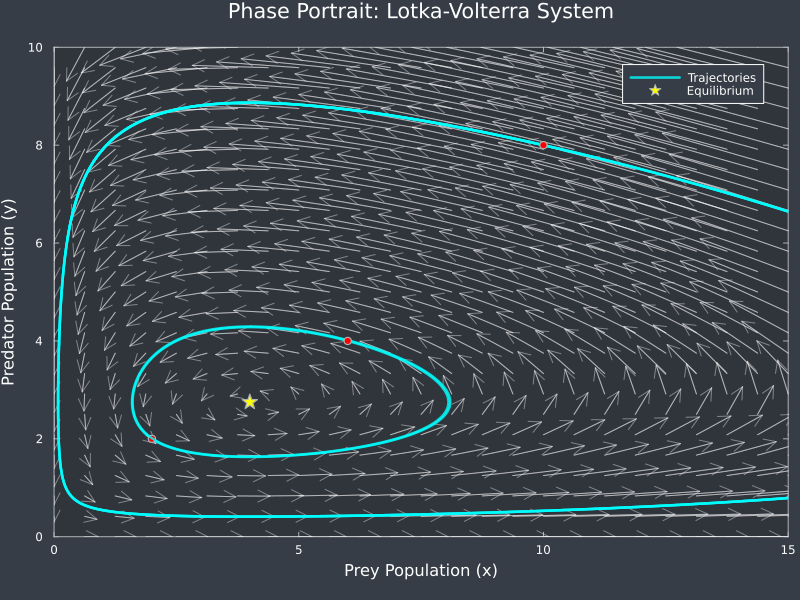

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


Visualization Complete.


In [5]:
# Set a dark scientific theme
theme(:dark)

# ------------------------------------------------------------------------------
# 1. Configuration & Parameters
# ------------------------------------------------------------------------------
module Config
    # System Parameters (Lotka-Volterra)
    # α: prey growth, β: predation rate, δ: predator death, γ: predator growth
    const P_SYS = (α = 1.1, β = 0.4, δ = 0.4, γ = 0.1)

    # Domain Bounds
    const X_LIM = (0.0, 15.0) # Prey population range
    const Y_LIM = (0.0, 10.0) # Predator population range

    # Grid Density for Vector Field
    const GRID_DENSITY = 25  # Number of points per axis

    # Visualization Styling
    const ARROW_SCALE = 0.35      # visual length of arrows
    const TRAJECTORY_TIME = (0.0, 40.0)
    const TRAJ_COLOR = :cyan
    const FIELD_COLOR_GRAD = :inferno
end

# ------------------------------------------------------------------------------
# 2. ODE Definition
# ------------------------------------------------------------------------------
"""
    system_dynamics!(du, u, p, t)

The differential equation definition.
u[1] = x (Prey), u[2] = y (Predator)
"""
function system_dynamics!(du, u, p, t)
    x, y = u
    α, β, δ, γ = p

    # dx/dt = αx - βxy
    du[1] = α * x - β * x * y
    
    # dy/dt = -δy + γxy
    du[2] = -δ * y + γ * x * y
end

# ------------------------------------------------------------------------------
# 3. Vector Field Computation
# ------------------------------------------------------------------------------
"""
    compute_vector_field(x_range, y_range, params)

Calculates the vector field (U, V) and Magnitude (M) over a grid.
"""
function compute_vector_field(x_rng, y_rng, p)
    # Create meshgrid
    x_grid = repeat(x_rng', length(y_rng), 1)
    y_grid = repeat(y_rng, 1, length(x_rng))
    
    u_grid = zeros(size(x_grid))
    v_grid = zeros(size(y_grid))
    mag_grid = zeros(size(x_grid))
    
    du = zeros(2)
    
    # Compute vectors at each grid point
    for i in eachindex(x_grid)
        state = [x_grid[i], y_grid[i]]
        system_dynamics!(du, state, p, 0.0) # t=0 for autonomous systems
        
        # Calculate magnitude
        magnitude = norm(du)
        mag_grid[i] = magnitude
        
        # Normalize for visualization (prevent giant arrows)
        # We perform a "soft" normalization to keep direction clear but bound length
        if magnitude > 0
            scaling = Config.ARROW_SCALE / (magnitude^0.4) # non-linear scaling for better visuals
            u_grid[i] = du[1] * scaling
            v_grid[i] = du[2] * scaling
        end
    end
    
    return x_grid, y_grid, u_grid, v_grid, mag_grid
end

# ------------------------------------------------------------------------------
# 4. Trajectory Simulation
# ------------------------------------------------------------------------------
"""
    solve_trajectory(u0, params)

Solves the ODE for a specific initial condition using DifferentialEquations.jl
"""
function solve_trajectory(u0, p)
    prob = ODEProblem(system_dynamics!, u0, Config.TRAJECTORY_TIME, p)
    # Tsit5 is a standard efficient solver for non-stiff ODEs
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    return sol
end

# ------------------------------------------------------------------------------
# 5. Main Visualization Routine
# ------------------------------------------------------------------------------
function main()
    println("Generating Vector Field Visualization...")

    # A. Setup Grid
    xs = range(Config.X_LIM[1], Config.X_LIM[2], length=Config.GRID_DENSITY)
    ys = range(Config.Y_LIM[1], Config.Y_LIM[2], length=Config.GRID_DENSITY)
    params =Values = (Config.P_SYS.α, Config.P_SYS.β, Config.P_SYS.δ, Config.P_SYS.γ)

    # B. Compute Field
    X, Y, U, V, Mag = compute_vector_field(xs, ys, params)

    # C. Initialize Plot
    plt = plot(
        title = "Phase Portrait: Lotka-Volterra System",
        xlabel = "Prey Population (x)",
        ylabel = "Predator Population (y)",
        xlims = Config.X_LIM,
        ylims = Config.Y_LIM,
        aspect_ratio = :equal,
        legend = :topright,
        grid = false,
        framestyle = :box,
        size = (800, 600)
    )

    # D. Plot Vector Field (Quiver)
    # We flatten the arrays because quiver expects vectors, not matrices
    quiver!(
        plt,
        vec(X), vec(Y),
        quiver = (vec(U), vec(V)),
        color = :white,
        alpha = 0.4,
        linewidth = 1.0,
        label = "Vector Field"
    )

    # E. Solve and Plot Trajectories
    # Define interesting initial conditions
    initial_conditions = [
        [2.0, 2.0],
        [6.0, 4.0],
        [10.0, 8.0]
    ]

    for (i, u0) in enumerate(initial_conditions)
        sol = solve_trajectory(u0, params)
        plot!(plt, sol, vars=(1, 2), 
              lw=2.5, 
              color=Config.TRAJ_COLOR, 
              alpha=0.8,
              label = i==1 ? "Trajectories" : "") # Only label the first one
        
        # Mark start points
        scatter!(plt, [u0[1]], [u0[2]], 
                 color=:red, marker=:circle, markersize=4, label=nothing)
    end

    # F. Add Fixed Point (Equilibrium)
    # For L-V: x* = δ/γ, y* = α/β
    eq_x = Config.P_SYS.δ / Config.P_SYS.γ
    eq_y = Config.P_SYS.α / Config.P_SYS.β
    scatter!(plt, [eq_x], [eq_y], 
             color=:yellow, marker=:star5, markersize=8, 
             label="Equilibrium")

    # Display final plot
    display(plt)
    println("Visualization Complete.")
end

# Execute
main()

Generando visualizaciones... Por favor espera.
Visualización completada exitosamente.


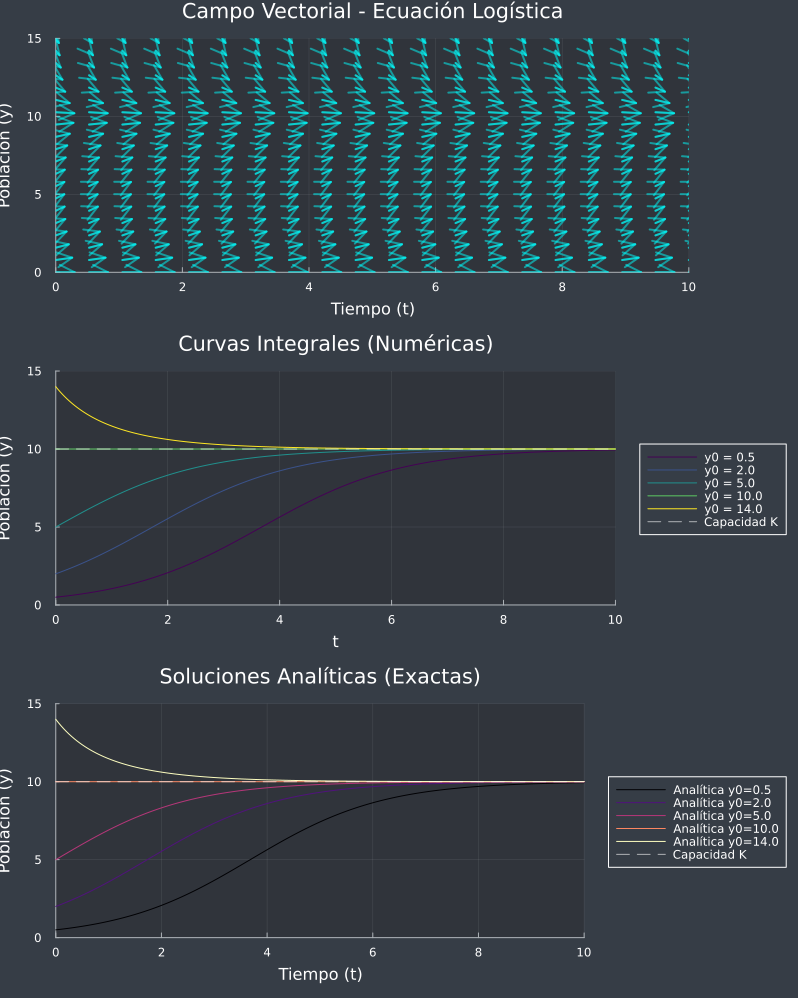

In [6]:
# ==============================================================================
# LOGISTIC ODE VISUALIZATION
# Script: Vector Fields, Integral Curves, and Analytical Solutions
# Author: Gemini (Scientific Programming Assistant)
# ==============================================================================

#using DifferentialEquations
#using Plots
#using LinearAlgebra

# ------------------------------------------------------------------------------
# 1. PARÁMETROS Y CONFIGURACIÓN
# ------------------------------------------------------------------------------
const r = 0.8          # Tasa de crecimiento
const K = 10.0         # Capacidad de carga
const t_span = (0.0, 10.0)
const y_range = (0.0, 15.0) # Ajustado para ver curvas por encima de K
const grid_density = 20
const y0_list = [0.5, 2.0, 5.0, 10.0, 14.0] # Condiciones iniciales

# Estilo Global de Gráficos
theme(:dark)
const PLOT_STYLE = Dict(
    :grid => true,
    :gridalpha => 0.2,
    :linewidth => 2,
    :xlabel => "Tiempo (t)",
    :ylabel => "Población (y)",
    :legend => :outerright #,
    #:background_color => :black
)

# ------------------------------------------------------------------------------
# 2. DEFINICIONES MATEMÁTICAS
# ------------------------------------------------------------------------------

# La EDO Logística: dy/dt = f(y, p, t)
function logistic_ode!(dy, y, p, t)
    r_val, K_val = p
    dy[1] = r_val * y[1] * (1 - y[1] / K_val)
end

# Solución Analítica: y(t) = K / (1 + ((K - y0)/y0) * exp(-rt))
function analytical_solution(t, y0, r_val, K_val)
    if y0 <= 0
        return 0.0
    end
    # Reordenado para evitar divisiones por cero innecesarias
    term = ((K_val - y0) / y0) * exp(-r_val * t)
    return K_val / (1 + term)
end

# ------------------------------------------------------------------------------
# 3. FUNCIONES DE VISUALIZACIÓN
# ------------------------------------------------------------------------------

"""
Genera el Campo Vectorial (Campo de pendientes) para la EDO.
"""
function plot_vector_field()
    t_vals = range(t_span[1], t_span[2], length=grid_density)
    y_vals = range(y_range[1], y_range[2], length=grid_density)
    
    dt_vec = Float64[]
    dy_vec = Float64[]
    pts_t = Float64[]
    pts_y = Float64[]

    scale = 0.3 # Escala de las flechas

    for t in t_vals, y in y_vals
        slope = r * y * (1 - y / K)
        
        # Normalización para uniformidad
        mag = sqrt(1.0 + slope^2)
        push!(dt_vec, (1.0 / mag) * scale)
        push!(dy_vec, (slope / mag) * scale)
        push!(pts_t, t)
        push!(pts_y, y)
    end

    return quiver(pts_t, pts_y, quiver=(dt_vec, dy_vec), 
           color=:cyan, alpha=0.5, 
           title="Campo Vectorial - Ecuación Logística",
           xlims=t_span, ylims=y_range; 
           PLOT_STYLE...)
end

"""
Calcula y grafica trayectorias numéricas.
"""
function plot_integral_curves()
    p = (r, K)
    plt = plot(title="Curvas Integrales (Numéricas)", 
               xlims=t_span, ylims=y_range; 
               PLOT_STYLE...)
    
    colors = palette(:viridis, length(y0_list))
    
    for (i, y0) in enumerate(y0_list)
        prob = ODEProblem(logistic_ode!, [y0], t_span, p)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
        plot!(plt, sol, vars=(0, 1), label="y0 = $y0", color=colors[i])
    end
    
    hline!(plt, [K], linestyle=:dash, color=:white, label="Capacidad K", alpha=0.6)
    return plt
end

"""
Grafica las soluciones analíticas de forma cerrada.
"""
function plot_analytical_solutions()
    plt = plot(title="Soluciones Analíticas (Exactas)", 
               xlims=t_span, ylims=y_range; 
               PLOT_STYLE...)
    
    t_fine = range(t_span[1], t_span[2], length=200)
    colors = palette(:magma, length(y0_list))

    for (i, y0) in enumerate(y0_list)
        y_vals = [analytical_solution(t, y0, r, K) for t in t_fine]
        plot!(plt, t_fine, y_vals, label="Analítica y0=$y0", color=colors[i])
    end
    
    hline!(plt, [K], linestyle=:dash, color=:white, label="Capacidad K", alpha=0.6)
    return plt
end

# ------------------------------------------------------------------------------
# 4. EJECUCIÓN Y COMPILACIÓN DE RESULTADOS
# ------------------------------------------------------------------------------

function main()
    println("Generando visualizaciones... Por favor espera.")
    
    # Crear los sub-gráficos
    p1 = plot_vector_field()
    p2 = plot_integral_curves()
    p3 = plot_analytical_solutions()
    
    # Combinar en un solo layout
    final_plot = plot(p1, p2, p3, layout=(3, 1), size=(800, 1000))
    
    # Mostrar el gráfico (Crucial para ejecución de script)
    display(final_plot)
    
    # Opcional: Guardar el resultado
    # savefig(final_plot, "logistic_viz.png")
    
    println("Visualización completada exitosamente.")
end

# Ejecutar el script
main()

# Referencias

- https://ritog.github.io/posts/1st-order-DE-julia/1st_order_DE_julia.html